In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import tensorflow as tf 
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
from pathlib import Path
import cv2

# Display F. Chollet example
import matplotlib
from skimage.transform import resize

from cgmml.common.evaluation.eval_utils import tf_load_pickle
from run_gradcam import show_depthmaps, overlay_depthmap_gradcam, extract_last_conv_layer_name, compute_preds_and_heatmaps

REPO_DIR = Path(os.getcwd()).parents[2].absolute()


In [2]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [3]:
output_location = (REPO_DIR / 'data' / 'q3-depthmap-plaincnn-height-95k')
model_file_path = (output_location / 'outputs' / 'best_model.ckpt')

#note:
#experiment_name = "q3-depthmap-plaincnn-height-95k"
#run_id = "q3-depthmap-plaincnn-height-95k_1629821224_3ce63344"  # Run 2


In [4]:
height_model = tf.keras.models.load_model(model_file_path, compile=False)

2021-10-21 10:38:23.375440: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-21 10:38:23.375962: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# Compile the model.
height_model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
            )

In [6]:
grad_model = height_model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
            )

In [37]:
#height_model.summary() 

### Download dataset and find some examples

In [38]:
# ALREADY DOWNLOADED
#dataset = Dataset.get_by_name(workspace, name='anon-depthmap-mini')
#dataset.download(target_path='./dataset', overwrite=False)

In [7]:
scan_paths = ["./dataset/scans/1585273581-kkzed7slcb/101/pc_1585273581-kkzed7slcb_1592533609843_101_011.p",
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_000.p", 
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_014.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_000.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_006.p"]

In [8]:
depthmaps = []

for path in scan_paths:
    normalization_value = 7.5
    depthmap, target = tf_load_pickle(path, normalization_value)
    depthmaps.append(depthmap)

depthmaps = np.array(depthmaps)
print(type(depthmaps[0]))
print(depthmaps[0].shape)
print(depthmaps.shape)


<class 'numpy.ndarray'>
(240, 180, 1)
(5, 240, 180, 1)


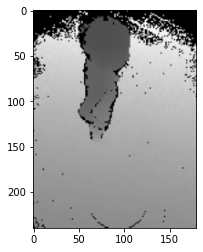

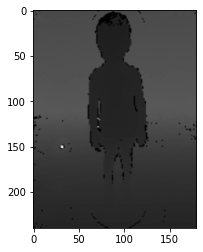

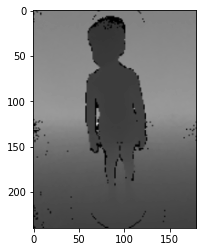

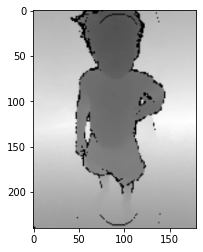

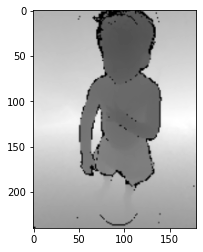

In [9]:
show_depthmaps(depthmaps)

### Prepare depthmap

In [10]:
#FROM CGM-RG

IMAGE_TARGET_HEIGHT = 240
IMAGE_TARGET_WIDTH = 180
NORMALIZATION_VALUE = 7.5

def preprocess_depthmap(depthmap):
    return depthmap.astype("float32")

def preprocess(depthmap):
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / NORMALIZATION_VALUE
    depthmap = resize(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    depthmap = depthmap.reshape((depthmap.shape[0], depthmap.shape[1], 1))
    return depthmap

In [11]:
preprocessed_depthmaps = []

for depthmap in depthmaps:
    preprocessed_depthmap = preprocess(depthmap)
    preprocessed_depthmaps.append(preprocessed_depthmap)
    
preprocessed_depthmaps = np.array(preprocessed_depthmaps)    

print(type(preprocessed_depthmaps))
print(len(preprocessed_depthmaps))
print(preprocessed_depthmaps[0].shape)
print(preprocessed_depthmaps.shape)

<class 'numpy.ndarray'>
5
(240, 180, 1)
(5, 240, 180, 1)


# Create heatmap

In [12]:
last_conv_layer_name = extract_last_conv_layer_name(height_model)
print(last_conv_layer_name)

conv2d_11


## 2nd Gradcam Implementation - with subgraph creation + two simultaneous ouputs

In [14]:
# from https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
# understand this implementation better: https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow

# THIS creates a connection between the inputs and our target outputs = output of last conv layer and height pred output = SUBGRAPH CREATION
# SUBGRAPH CREATION = obtain output from a specific layer
grad_model = Model(inputs=[height_model.inputs], 
                        outputs=[height_model.get_layer(last_conv_layer_name).output, height_model.output])

In [17]:
heatmaps_res, heightpreds_res = compute_preds_and_heatmaps(preprocessed_depthmaps, grad_model)

(240, 180, 1)
(1, 240, 180, 1)
pred.shape =  (1, 1)
predictions tf.Tensor([[84.25936]], shape=(1, 1), dtype=float32)
predictions[0] tf.Tensor([84.25936], shape=(1,), dtype=float32)
(240, 180, 1)
(1, 240, 180, 1)
pred.shape =  (1, 1)
predictions tf.Tensor([[90.03042]], shape=(1, 1), dtype=float32)
predictions[0] tf.Tensor([90.03042], shape=(1,), dtype=float32)
(240, 180, 1)
(1, 240, 180, 1)
pred.shape =  (1, 1)
predictions tf.Tensor([[90.0126]], shape=(1, 1), dtype=float32)
predictions[0] tf.Tensor([90.0126], shape=(1,), dtype=float32)
(240, 180, 1)
(1, 240, 180, 1)
pred.shape =  (1, 1)
predictions tf.Tensor([[90.16492]], shape=(1, 1), dtype=float32)
predictions[0] tf.Tensor([90.16492], shape=(1,), dtype=float32)
(240, 180, 1)
(1, 240, 180, 1)
pred.shape =  (1, 1)
predictions tf.Tensor([[86.71371]], shape=(1, 1), dtype=float32)
predictions[0] tf.Tensor([86.71371], shape=(1,), dtype=float32)


In [18]:
height_model.predict(preprocessed_depthmaps)

2021-10-21 10:41:53.538804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


array([[84.25936 ],
       [90.03043 ],
       [90.01261 ],
       [90.16492 ],
       [86.713715]], dtype=float32)

# write test case for the above: ensure that grad_model ehight result and height_model.predict return the same height predictions

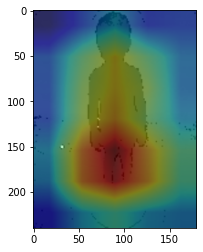

array([[[  0,   0,  51],
        [ 28,  28,  78],
        [ 44,  44,  95],
        ...,
        [ 44,  67, 146],
        [ 44,  67, 146],
        [ 44,  67, 146]],

       [[ 28,  28,  78],
        [ 38,  38,  89],
        [ 44,  44,  95],
        ...,
        [ 44,  67, 146],
        [ 44,  67, 146],
        [ 44,  67, 146]],

       [[ 44,  44,  95],
        [ 44,  44,  95],
        [ 44,  44,  95],
        ...,
        [ 34,  56, 136],
        [ 34,  57, 136],
        [ 44,  67, 146]],

       ...,

       [[  8,   8, 110],
        [ 17,  17, 118],
        [ 22,  22, 124],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]],

       [[  0,   0, 102],
        [  8,   8, 110],
        [ 17,  17, 118],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]],

       [[  0,   0, 102],
        [  0,   0, 102],
        [  8,   8, 110],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]]

In [21]:
depthmap_test = preprocessed_depthmaps[1]
depthmap_test = np.expand_dims(depthmap_test, axis=0)
heatmap_test = heatmaps_res[1]

overlay_depthmap_gradcam(depthmap_test, heatmap_test)

___________________________________________________________________